<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np
import pickle
import tensorflow_addons as tfa

In [2]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [3]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])

dim             = fixed_num_bins

optimizer       = tf.keras.optimizers.Adam
batchsize       = 33
decay_steps     = 2300
dropouts_dec    = [0.]
dropouts_enc    = [0.]
latent_dim      = 10
lr_final        = 1.3e-05
lr_init         = 7e-4
out_features    = [1000,590]

def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True,spec_norm=False):
    x = Flatten()(x)
    if spec_norm:
        x = tfa.layers.SpectralNormalization(Dense(num))(x)
    else:
        x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return x


def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback],verbose=0)
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [4]:
try:
    train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))
    print('data loaded from file')
except:
    train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_))
    valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_))
    test_data = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_))


    keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass','SN','MJD','plate','fiber', 'mean', 'std')

    train = {}
    for item, key in zip(train_data.files, keys):
        train[key] = train_data[item]


    valid = {}
    for item, key in zip(valid_data.files, keys):
        valid[key] =  valid_data[item]

    test = {}
    for item, key in zip(test_data.files, keys):
        test[key] = test_data[item]


    le = preprocessing.LabelEncoder()
    le.fit(train['subclass'])
    train['subclass'] = le.transform(train['subclass'])
    valid['subclass'] = le.transform(valid['subclass'])
    test['subclass']  = le.transform(test['subclass'])
    print(le.classes_, le.transform(le.classes_))        

    pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'wb'))


data loaded from file


In [5]:
test['fiber']

array([ 94, 537, 161, ...,  85, 343, 555])

In [6]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

n_layers   = 3
latent_dim = latent_dim

x = input
for ii in range(n_layers-1):
    if ii>0:
        x = Dropout(dropouts_enc[ii-1])(x)
    x = dense_block(x,out_features[ii],spec_norm=True)
    
x = dense_block(x,latent_dim,non_lin=False)
x = Reshape((latent_dim,1))(x)

for ii in range(n_layers-1):
    if conditional:
        x = dense_cond_block(x,z,out_features[-1-ii])
    else:
        x = dense_block(x,out_features[-1-ii])
    if ii ==0:
        pass
    else:
        x = Dropout(dropouts_dec[ii-1])(x)
if conditional:
    x = dense_cond_block(x,z,dim, non_lin=False)
else:
    x = dense_block(x,dim, non_lin=False)


learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
lr_init,
decay_steps,
lr_final,
power=0.5, cycle=True)

optim = optimizer

lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
lstm_ae.summary()



Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1000)         0           input_1[0][0]                    
__________________________________________________________________________________________________
spectral_normalization (Spectra (None, 1000)         1002000     flatten[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1000)         0           spectral_normalization[0][0]     
_______________________________________________________________________________________

In [8]:
path = os.path.join(root_models,'full_ae_model_%s_run%s_spec_norm'%(label_2,RUN))

lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)

print('final validation loss:', recon_error)
print('final validation reconstruction error:', np.sqrt(recon_error))


lstm_ae.save(path)

Epoch 1/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 4.6702
Epoch 2/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 4.8106
Epoch 3/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 1.9621
Epoch 4/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 1.8078
Epoch 5/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 1.7432
Epoch 6/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 1.6387
Epoch 7/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 1.5931
Epoch 8/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 1.5434
Epoch 9/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 1.5137
Epoch 10/40
2131/2131 [==============================] - 3s 2ms/step - training_loss: 1.4948
Epoch 11/40
2131/2131 [==============================] - 3s 2ms/step - training

In [9]:
for label in np.arange(7):
    print(le.inverse_transform([label]))
    index = np.where(valid['subclass']==label)[0]
    res_valid = lstm_ae.predict((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]))
    print('validation: ', custom_metric((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]),res_valid))
    index = np.where(train['subclass']==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]))
    print('training: ', custom_metric((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]),res_train))

[b'']
validation:  1.2618984724169429
training:  1.2494336153187027
[b'AGN']
validation:  1.3674821005664493
training:  1.6065936048926612
[b'AGN BROADLINE']
validation:  2.1987605579111995
training:  1.742234172508336
[b'BROADLINE']
validation:  1.7975428175665489
training:  1.646395300445006
[b'STARBURST']
validation:  1.5995802077114232
training:  1.538240576332985
[b'STARBURST BROADLINE']
validation:  1.7042355793934696
training:  1.705298837814618
[b'STARFORMING']
validation:  1.3795207120899187
training:  1.3683037485911331


In [10]:
def bootstrap(train_data, batch_size):
    index   = np.arange(len(train['spec']))
    metrics = []
    for ii in range(1000):
        sample    = np.random.choice(index, size=batch_size, replace=False, p=None)
        res_train = lstm_ae.predict((train['spec'][sample],train['mask'][sample],train['noise'][sample], train['subclass'][sample],train['z'][sample]))
        metric    = custom_metric((train['spec'][sample],train['mask'][sample],train_data['noise'][sample], train['subclass'][sample],train['z'][sample]),res_train)
        metrics.append(metric)
    return np.mean(metrics), np.std(metrics)

In [12]:
bootstrap(train, batch_size=len(valid['spec']))

(1.320302302673197, 0.004253808432727904)

In [13]:
### concatenate and split input
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [14]:
def extract_layers_base(main_model, starting_layer_ix, ending_layer_ix):
    layers=[]
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        layers.append(curr_layer)
    return layers

In [15]:
encoder = extract_layers(lstm_ae,0,13)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aaba79c8400>
1 <tensorflow.python.keras.layers.core.Flatten object at 0x2aaba79e9e80>
2 <tensorflow.python.keras.layers.core.Dense object at 0x2aaba7c14880>
3 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aaba7c14fd0>
4 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaba7c14df0>
5 <tensorflow.python.keras.layers.core.Dropout object at 0x2aaba7c45ee0>
6 <tensorflow.python.keras.layers.core.Flatten object at 0x2aaba7c45df0>
7 <tensorflow.python.keras.layers.core.Dense object at 0x2aaba8086c70>
8 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aaba80b1ca0>
9 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaba80b19a0>
10 <tensorflow.python.keras.layers.core.Flatten object at 0x2aaba79e9eb0>
11 <tensorflow.python.keras.layers.core.Dense object at 0x2aaba80c25e0>
12 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaba80cbdf0>
Model: "

In [16]:
if conditional:
    decoder = extract_layers_base(lstm_ae,13,25)
    input      = Input(shape=(latent_dim,1))
    input_type = Input(shape=(1,1))
    print(decoder[0])
    x          = decoder[0]((input,input_type))
    for ii in range(1,len(decoder)):
        try:
            x = decoder[ii](x)
        except:
            x = decoder[ii]((x, input_type))
    decoder = Model((input,input_type),x)
else:
    decoder = extract_layers(lstm_ae,13,25)
    decoder.build((None,latent_dim,1))

13 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaba80b1a60>
14 <tensorflow.python.keras.layers.core.Flatten object at 0x2aaba80cbaf0>
15 <tensorflow.python.keras.layers.core.Dense object at 0x2aaba80d3550>
16 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aaba80e46d0>
17 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaba80e4370>
18 <tensorflow.python.keras.layers.core.Flatten object at 0x2aaba80e4580>
19 <tensorflow.python.keras.layers.core.Dense object at 0x2aaba80e82e0>
20 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aaba80f1880>
21 <tensorflow.python.keras.layers.core.Reshape object at 0x2aaba80f1af0>
22 <tensorflow.python.keras.layers.core.Dropout object at 0x2aaba80f1640>
23 <tensorflow.python.keras.layers.core.Flatten object at 0x2aaba80cbbb0>
24 <tensorflow.python.keras.layers.core.Dense object at 0x2aaba80f4d00>


In [17]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 590)               6490      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 590)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 590, 1)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 590)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)             

In [18]:
encoded_valid = encoder.predict(valid['spec'])
encoded_train = encoder.predict(train['spec'])
encoded_test  = encoder.predict(test['spec'])

In [19]:
if conditional:
    decoded_train  = decoder.predict((np.expand_dims(encoded_train,-1), np.expand_dims(train['subclass'],-1)))
    decoded_test   = decoder.predict((np.expand_dims(encoded_test,-1), np.expand_dims(test['subclass'],-1)))
    decoded_valid  = decoder.predict((np.expand_dims(encoded_valid,-1), np.expand_dims(valid['subclass'],-1)))
else:
    decoded_train  = decoder.predict(encoded_train)
    decoded_test   = decoder.predict(encoded_test)
    decoded_valid  = decoder.predict(encoded_valid)   

In [20]:
path = os.path.join(root_models,'encoder_%s_run%s'%(label_2, RUN))
encoder.save(path)
path = os.path.join(root_models,'decoder_%s_run%s'%(label_2, RUN))
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1


In [21]:
path = os.path.join(root_models,'encoder_%s_run%s'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [22]:
encoded_valid = np.squeeze(encoded_valid)
encoded_train = np.squeeze(encoded_train)
encoded_test  = np.squeeze(encoded_test)

In [23]:
np.save(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2,RUN)),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)

In [24]:
np.save(os.path.join(root_decoded,'decoded_%s.npy'%label_2),[decoded_train,decoded_valid, decoded_test, train['mean'], train['std']])

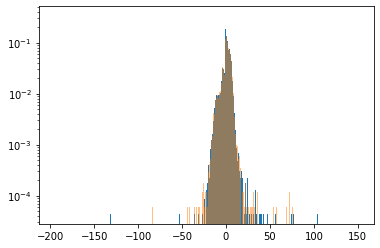

In [25]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

In [26]:
encoded_valid.shape

(6596, 10)

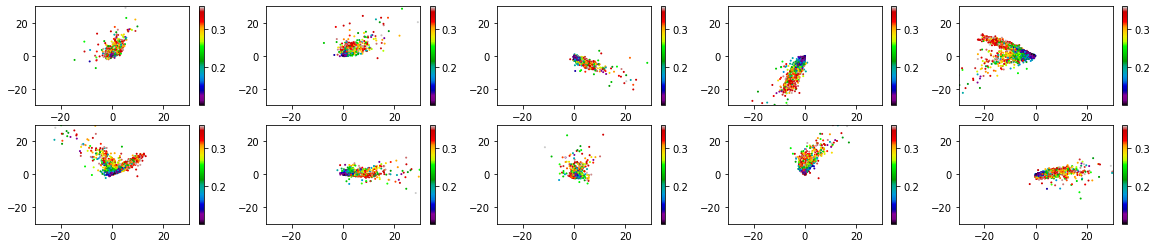

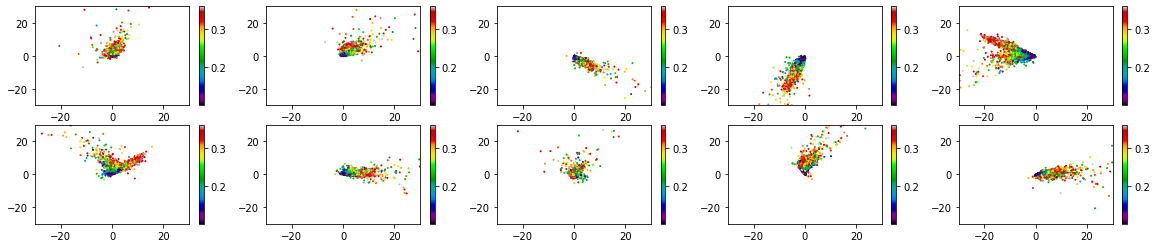

In [27]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['z'], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:len(encoded_valid),ii],encoded_train[:len(encoded_valid),jj],c=train['z'][:len(encoded_valid)], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

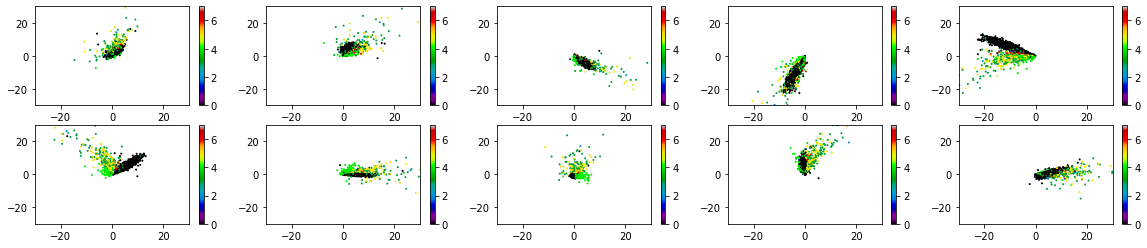

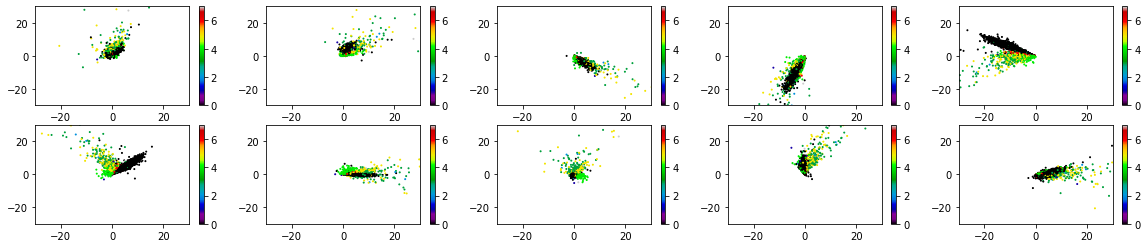

In [28]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['subclass'], cmap='nipy_spectral', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:len(encoded_valid),ii],encoded_train[:len(encoded_valid),jj],c=train['subclass'][:len(encoded_valid)], cmap='nipy_spectral', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [29]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

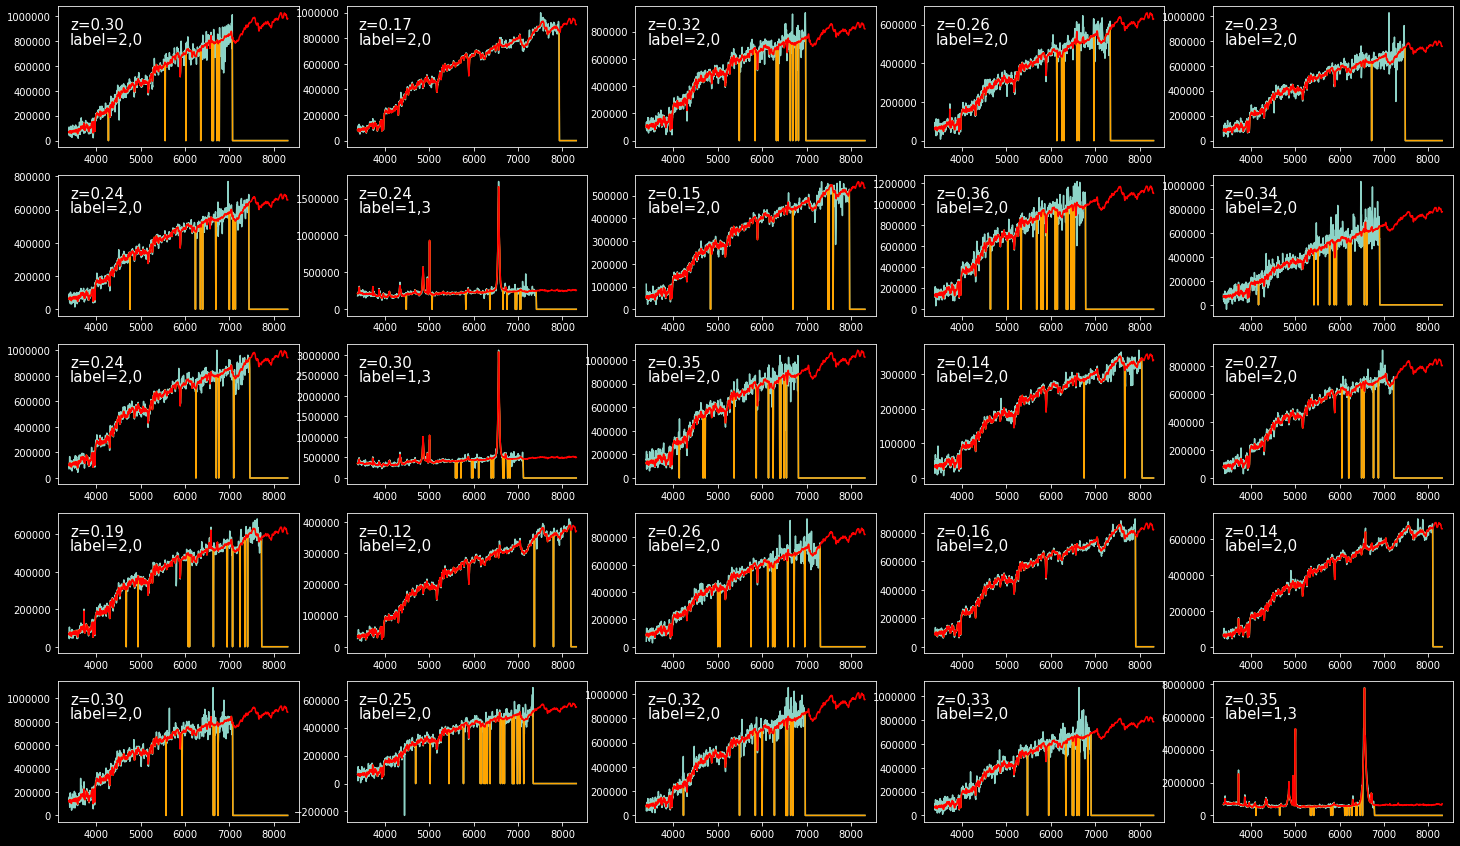

In [30]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec']*train['std'])[ii]+train['mean'])*np.squeeze(valid['mask'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*train['std'])[ii]+train['mean'])*np.squeeze(valid['mask'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*train['std'])[ii]+train['mean']), color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid['z'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid['class'][ii],valid['subclass'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

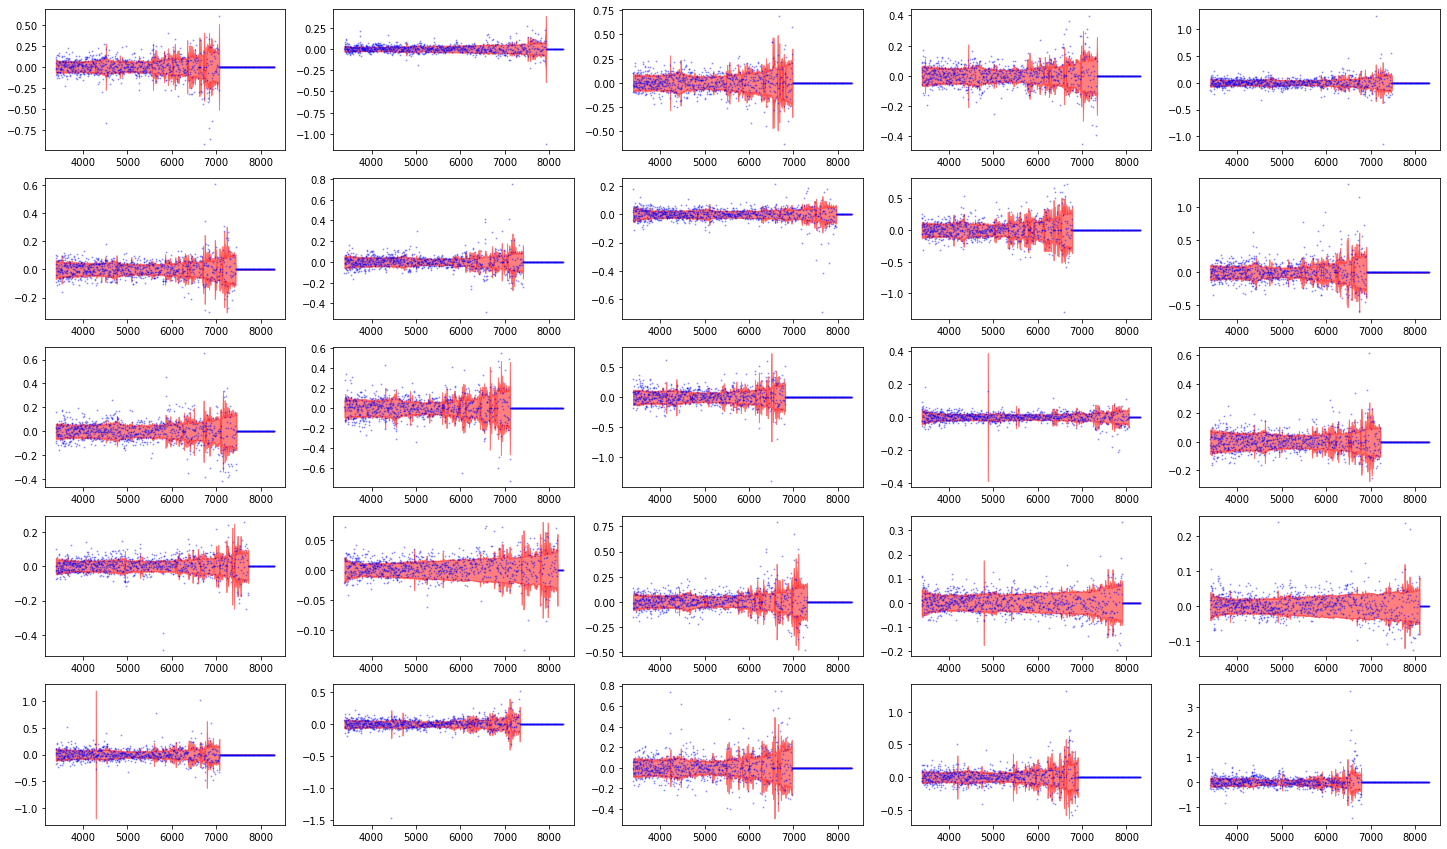

In [31]:
noise = np.zeros(valid['noise'].shape)
ind   = np.where(valid['noise']!=0)
noise[ind] = np.sqrt(1./np.squeeze(valid['noise'][ind]))

noise = np.squeeze(noise)


fig, ax = plt.subplots(5,5, figsize=(25,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(25)):
    ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec'])[ii]-decoded_valid[ii])*np.squeeze(valid['mask'][ii]),color='blue', alpha=0.3,ls='',marker='o', markersize=1)
    ax[nn].fill_between(new_wl[:-1], -noise[ii], noise[ii], alpha=0.5, color='red')               
plt.show()

In [32]:
### Look at reconstruction ability as function of wavelength

In [33]:
def loss_by_wl(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [34]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

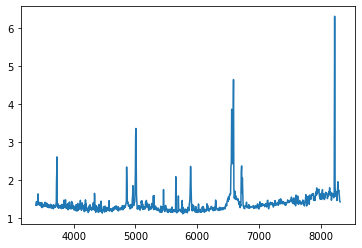

In [35]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0))

In [36]:
np.mean(loss[0]/np.mean(valid['mask'],axis=0))

1.3642763329838672

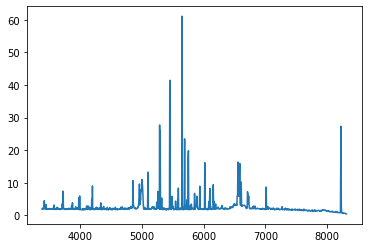

In [37]:
plt.plot(new_wl[:-1],loss[1])

In [38]:
np.tile(np.expand_dims(encoded_valid[0],(0,-1)),(8,1,1)).shape, np.expand_dims(np.arange(8),-1).shape

((8, 10, 1), (8, 1))

In [70]:
encoded_train.shape

(70311, 10)